### Load data and import necessary library

In [1]:
#Import necessary library
import pickle as pkl
from itertools import cycle
from sklearn.preprocessing import label_binarize
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from xgboost import XGBClassifier
from scipy.stats import zscore, norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [53]:
# Import data
task1 = pd.read_csv('./converted_data/converted_data.csv')
task2 = pd.read_csv('./converted_data/df_labels_balanced_converted.csv')

In [3]:
task1.head()

,iscancerous,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p2177,p2178,p2179,p2180,p2181,p2182,p2183,p2184,p2185,p2186
0,0,164,124,180,146,108,169,172,134,199,...,222,163,115,188,160,113,185,168,122,191
1,0,241,236,240,242,234,239,240,229,237,...,158,151,107,179,138,91,175,101,54,142
2,0,250,240,252,254,244,255,239,228,246,...,230,243,216,237,239,209,231,246,213,238
3,0,255,237,255,243,224,242,238,222,233,...,187,202,118,163,183,97,147,200,114,167
4,0,222,198,219,230,204,227,218,186,215,...,245,244,212,229,241,204,226,235,195,221


## Evaluation Metrics

In [110]:
def plot_multiclass_roc(clf, X_test, y_test):
    figsize=(17, 6)
    y_score = clf.predict_proba(X_test)
    n_classes = len(np.unique(y_test))


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()


In [79]:
len(y_train.value_counts())

4

In [113]:
from sklearn.metrics import RocCurveDisplay
# Use this function to train and evaluate the model. If the model is a neural network, 
# change model_type to 'tf' and specified the trainning epochs
def train_and_plot(model, X_train , y_train , X_test, y_test, model_type = 'sk', epochs = 0):

    if model_type == 'sk' :
        model.fit(X_train, y_train)
        print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
        print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
        
        # fpr, tpr, thresholds = macro_roc(y_test, model.predict(X_test), n_classes = len(y_train.value_counts()))
        # roc_curve(y_test, model.predict_proba(X_test)[:,1])
    elif model_type == 'tf' :
        model.fit(X_train, y_train, epochs = epochs, verbose = 2)
        print('Model accuracy for train set: {0:.3f}'.format(model.evaluate(X_train, y_train, verbose=0)[1]))
        print('Model accuracy for test set: {0:.3f}'.format(model.evaluate(X_test, y_test, verbose=0)[1]))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)
    plot_confusion_matrix(model, X_test, y_test)
    plt.title('Confusion Matrix')

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', auc.round(3))
    
    plot_multiclass_roc(model, X_test, y_test)
    

    
    return model

## Traditional Machine learning model

In [5]:
# Task 1: cancer classification
converted_data.head()

,iscancerous,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p2177,p2178,p2179,p2180,p2181,p2182,p2183,p2184,p2185,p2186
0,0,164,124,180,146,108,169,172,134,199,...,222,163,115,188,160,113,185,168,122,191
1,0,241,236,240,242,234,239,240,229,237,...,158,151,107,179,138,91,175,101,54,142
2,0,250,240,252,254,244,255,239,228,246,...,230,243,216,237,239,209,231,246,213,238
3,0,255,237,255,243,224,242,238,222,233,...,187,202,118,163,183,97,147,200,114,167
4,0,222,198,219,230,204,227,218,186,215,...,245,244,212,229,241,204,226,235,195,221


In [114]:
def set_gen(input_df, key = 'iscancerous') :
    X = input_df.drop(key, axis = 1)
    y = input_df[key]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42, shuffle = True, stratify = y)
    return X_train, X_test, y_train, y_test

In [115]:
X_train, X_test, y_train, y_test = set_gen(task1)

In [116]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18270, 2187)
(18270,)
(7830, 2187)
(7830,)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model accuracy for train set: 1.000
Model accuracy for test set: 0.915

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3915
           1       0.90      0.93      0.92      3915

    accuracy                           0.92      7830
   macro avg       0.92      0.92      0.92      7830
weighted avg       0.92      0.92      0.92      7830


Confusion Matrix:
 [[3508  407]
 [ 255 3660]]

Accuracy Score:  0.915


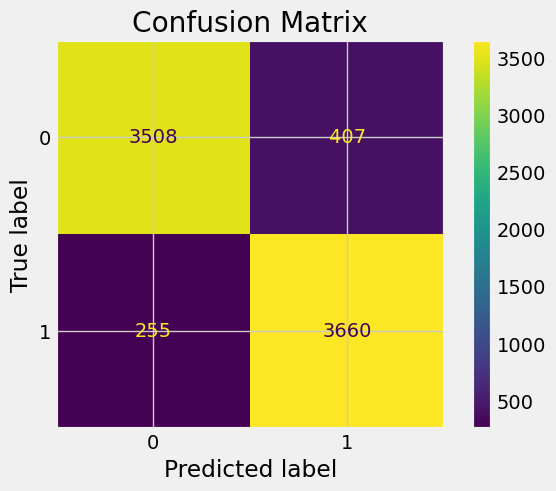

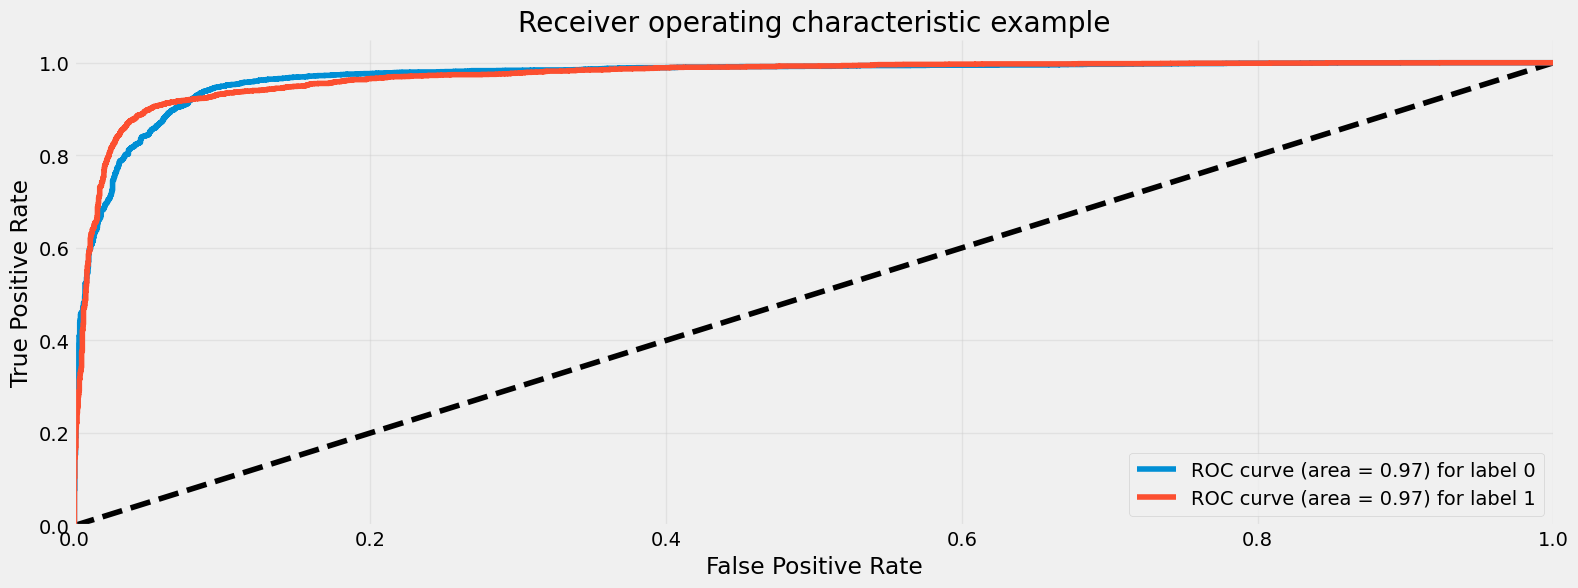

In [117]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, n_jobs=-1)
xgb_vanilla = train_and_plot(xgb_clf, X_train, y_train, X_test, y_test)

In [10]:
# save model
pkl.dump(xgb_vanilla, open('./model_result/xgb_standard.pkl', "wb"))

### XGBOOST Hyperparameter tunning

In [26]:
!pip3 install optuna
! pip install optuna-dashboard
## Run this command in a seperate terminal- min trail is 100
# optuna-dashboard sqlite:///db.sqlite3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 8.9 MB/s eta 0:00:00
Listening on http://127.0.0.1:8080/
Hit Ctrl-C to quit.

127.0.0.1 - - [10/Jan/2023 22:20:33] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [10/Jan/2023 22:20:33] "GET /dashboard HTTP/1.1" 200 4145
127.0.0.1 - - [10/Jan/2023 22:20:33] "GET /static/bundle.js HTTP/1.1" 200 1242148
127.0.0.1 - - [10/Jan/2023 22:20:33] "GET /api/studies HTTP/1.1" 200 23
127.0.0.1 - - [10/Jan/2023 22:20:33] "GET /favicon.ico HTTP/1.1" 200 7670
127.0.0.1 - - [10/Jan/2023 22:26:02] "GET / HTTP/1.1" 302 0
127.0.0.1 - - [10/Jan/2023 22:26:02] "GET /dashboard HTTP/1.1" 304 0
127.0.0.1 - - [10/Jan/2023 22:26:02] "GET /static/bundle.js HTTP/1.1" 304 0
127.0.0.1 - - [10/Jan/2023 22:26:02] "GET /api/studies HTTP/1.1" 200 23
^C
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/bin/optuna-dashboard", line 8, in <modu

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
import optuna


def objective(trial):
    
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 40) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'
    
    pipeline = Pipeline([
        ("scaler", scaler),
        ("dim_red", dimen_red_algorithm),
        #Can change if gpu support is implementted
        ("xgboost", XGBClassifier(n_jobs=-1))
    ])
    
        
    """Define the objective function"""
    params = {
        'xgboost__max_depth': trial.suggest_int('max_depth', 1, 9),
        'xgboost__learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'xgboost__n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'xgboost__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'xgboost__gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'xgboost__subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'xgboost__colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'xgboost__reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'xgboost__reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'xgboost__eval_metric': 'mlogloss',
        'xgboost__use_label_encoder': False
    }


    # Fit the model
    model = pipeline.set_params(**params)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="xgboost_tuned_100_trail")

[I 2023-01-10 22:58:49,733] A new study created in RDB with name: xgboost_tuned_100_trail


In [12]:
study.optimize(objective, n_trials=100)

[I 2023-01-10 22:58:54,038] Trial 0 finished with value: 0.8386973180076628 and parameters: {'scalers': 'robust', 'dim_red': None, 'max_depth': 4, 'learning_rate': 0.07513571586222301, 'n_estimators': 123, 'min_child_weight': 2, 'gamma': 4.053089094593123e-06, 'subsample': 0.01182438117684679, 'colsample_bytree': 0.022994699149711556, 'reg_alpha': 0.00019560668518842978, 'reg_lambda': 0.017140626779000138}. Best is trial 0 with value: 0.8386973180076628.
[I 2023-01-10 22:58:59,907] Trial 1 finished with value: 0.7908045977011494 and parameters: {'scalers': 'minmax', 'dim_red': 'PCA', 'pca_n_components': 30, 'max_depth': 3, 'learning_rate': 0.49327862087749846, 'n_estimators': 219, 'min_child_weight': 8, 'gamma': 0.3648049313301899, 'subsample': 0.02988718665522171, 'colsample_bytree': 0.037593061907333615, 'reg_alpha': 0.010763870972919058, 'reg_lambda': 0.9936610626469946}. Best is trial 0 with value: 0.8386973180076628.
[I 2023-01-10 22:59:09,233] Trial 2 finished with value: 0.85862

In [126]:
def print_res(input_study):
    print('Number of finished trials: {}'.format(len(input_study.trials)))
    print('Best trial:')
    trial = input_study.best_trial

    print('  Value: {}'.format(trial.value))
    print('  Params: ')

    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

print_res(study)

Number of finished trials: 100
Best trial:
  Value: 0.9259259259259259
  Params: 
    colsample_bytree: 0.9933990872908748
    dim_red: None
    gamma: 0.16773175473025118
    learning_rate: 0.138201994909766
    max_depth: 7
    min_child_weight: 3
    n_estimators: 442
    reg_alpha: 0.15070071468168292
    reg_lambda: 0.99558474460022
    scalers: minmax
    subsample: 0.6614827304636092


In [15]:
# Save the model to a pickle file
with open("./model_result/xg_boost_tuned.pkl", "wb") as f:
    pkl.dump(study.best_trial, f)

In [40]:
# Extract the parameter
import collections


'minmax'

In [135]:
def get_params(input_study) :
    params = {k: v for k, v in input_study.best_params.items() if k not in ('dim_red', 'scalers')}
    change = []
    for k,v in dict(params).items():
        tmp_name = k
        if 'xgboost' not in tmp_name :
            res = f"xgboost__{tmp_name}"
            params[res] = params.pop(tmp_name)
            change.append(res)
    return params

params = get_params(study)

In [136]:
params

{'xgboost__colsample_bytree': 0.9933990872908748,
 'xgboost__gamma': 0.16773175473025118,
 'xgboost__learning_rate': 0.138201994909766,
 'xgboost__max_depth': 7,
 'xgboost__min_child_weight': 3,
 'xgboost__n_estimators': 442,
 'xgboost__reg_alpha': 0.15070071468168292,
 'xgboost__reg_lambda': 0.99558474460022,
 'xgboost__subsample': 0.6614827304636092}

In [48]:
# Retrain the model with the parameter
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("xgboost", XGBClassifier(n_jobs=-1))
])

pipeline.set_params(**params)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9933990872908748,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.16773175473025118,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.138201994909766, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, n_estimators=442,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

Model accuracy for train set: 1.000
Model accuracy for test set: 0.926

              precision    recall  f1-score   support

           0       0.94      0.91      0.92      3915
           1       0.91      0.94      0.93      3915

    accuracy                           0.93      7830
   macro avg       0.93      0.93      0.93      7830
weighted avg       0.93      0.93      0.93      7830


Confusion Matrix:
 [[3569  346]
 [ 234 3681]]

Accuracy Score:  0.926


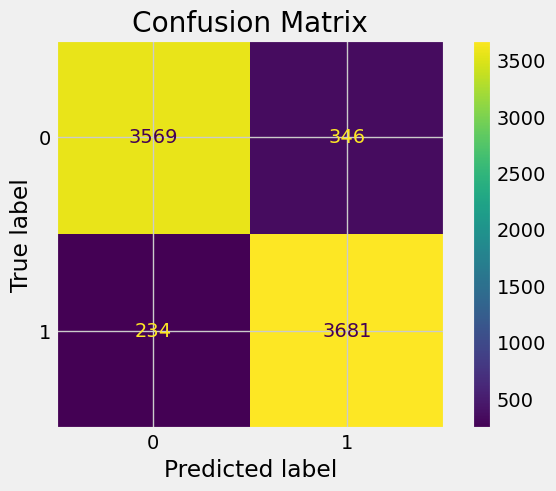

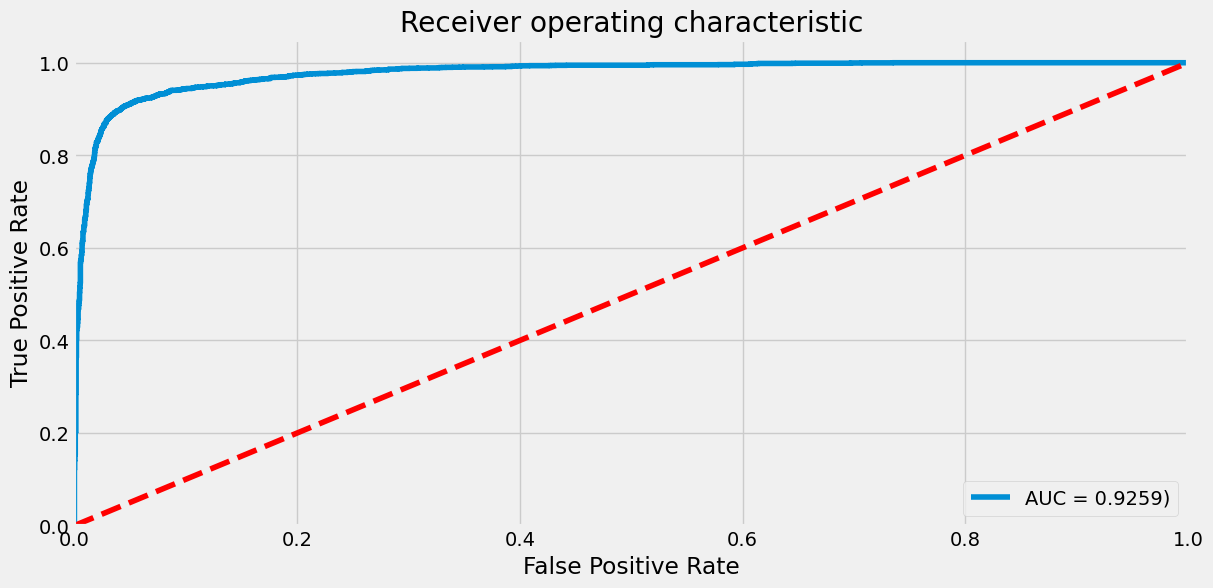

In [49]:
res = train_and_plot(pipeline)

## Task 2

In [120]:
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = set_gen(task2, key = 'celltype')
print(X_train_task2.shape)
print(y_train_task2.shape)
print(X_test_task2.shape)
print(y_test_task2.shape)

(11376, 2187)
(11376,)
(4876, 2187)
(4876,)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model accuracy for train set: 1.000
Model accuracy for test set: 0.908

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1219
           1       0.87      0.88      0.88      1219
           2       0.91      0.89      0.90      1219
           3       0.96      0.91      0.93      1219

    accuracy                           0.91      4876
   macro avg       0.91      0.91      0.91      4876
weighted avg       0.91      0.91      0.91      4876


Confusion Matrix:
 [[1166   17   33    3]
 [  43 1076   67   33]
 [  48   76 1082   13]
 [  39   64   12 1104]]

Accuracy Score:  0.908


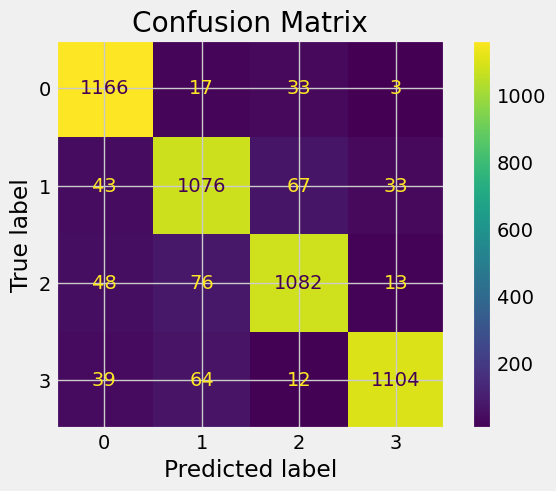

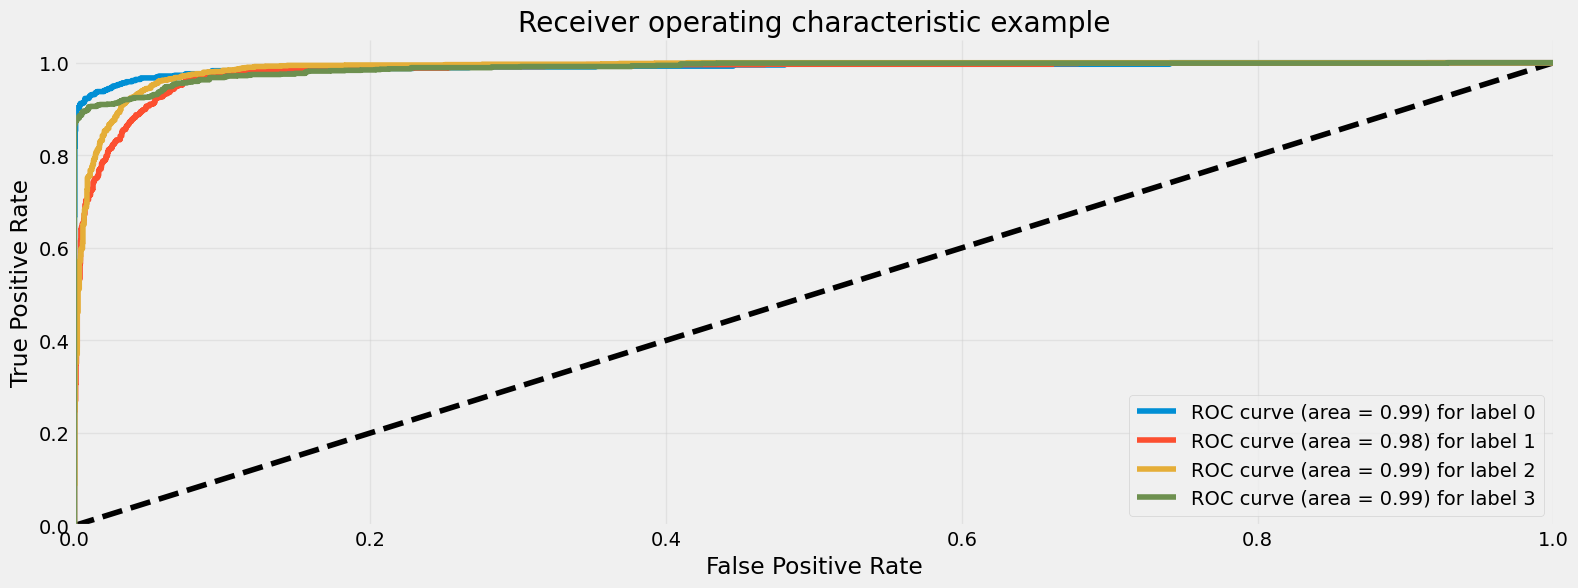

In [121]:
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, n_jobs=-1)
xgb_vanilla_task2 = train_and_plot(xgb_clf, X_train_task2, y_train_task2, X_test_task2, y_test_task2)

## Tuned Xgboost model

In [123]:
def objective(trial):
    
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
#Get minmax scaller

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 40) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'
    
    pipeline = Pipeline([
        ("scaler", scaler),
        ("dim_red", dimen_red_algorithm),
        #Can change if gpu support is implementted
        ("xgboost", XGBClassifier(n_jobs=-1))
    ])
    
        
    """Define the objective function"""
    params = {
        'xgboost__max_depth': trial.suggest_int('max_depth', 1, 9),
        'xgboost__learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'xgboost__n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'xgboost__min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'xgboost__gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'xgboost__subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'xgboost__colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'xgboost__reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'xgboost__reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'xgboost__eval_metric': 'mlogloss',
        'xgboost__use_label_encoder': False
    }


    # Fit the model
    model = pipeline.set_params(**params)
    model.fit(X_train_task2, y_train_task2)

    # Make predictions
    y_pred = model.predict(X_test_task2)

    # Evaluate predictions
    accuracy = accuracy_score(y_test_task2, y_pred)
    return accuracy

study2 = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
                            study_name="task2_xgboost_tuned_100_trail")

[I 2023-01-11 08:23:08,423] A new study created in RDB with name: task2_xgboost_tuned_100_trail


In [124]:
study2.optimize(objective, n_trials=100)

[I 2023-01-11 08:23:15,604] Trial 0 finished with value: 0.6447908121410992 and parameters: {'scalers': 'standard', 'dim_red': 'PCA', 'pca_n_components': 19, 'max_depth': 6, 'learning_rate': 0.010700171219224735, 'n_estimators': 116, 'min_child_weight': 8, 'gamma': 2.084290569150062e-07, 'subsample': 0.16360162591716065, 'colsample_bytree': 0.08025089552447127, 'reg_alpha': 1.2368123154345101e-08, 'reg_lambda': 2.5933444500447345e-05}. Best is trial 0 with value: 0.6447908121410992.
[I 2023-01-11 08:24:32,842] Trial 1 finished with value: 0.8468006562756357 and parameters: {'scalers': 'standard', 'dim_red': None, 'max_depth': 9, 'learning_rate': 0.01838294735040006, 'n_estimators': 75, 'min_child_weight': 10, 'gamma': 0.0035488195240737327, 'subsample': 0.47191495794000327, 'colsample_bytree': 0.8148782779095216, 'reg_alpha': 0.00013596506891284905, 'reg_lambda': 0.00024220384114942976}. Best is trial 1 with value: 0.8468006562756357.
[I 2023-01-11 08:24:40,090] Trial 2 finished with v

In [127]:
print_res(study2)

Number of finished trials: 100
Best trial:
  Value: 0.9144790812141099
  Params: 
    colsample_bytree: 0.1903724790238091
    dim_red: None
    gamma: 8.522160223316398e-07
    learning_rate: 0.08148568143867055
    max_depth: 7
    min_child_weight: 5
    n_estimators: 454
    reg_alpha: 0.001218625646365999
    reg_lambda: 2.6173337217980346e-08
    scalers: minmax
    subsample: 0.5446557397613256


In [128]:
with open("./model_result/task2_xg_boost_tuned.pkl", "wb") as f:
    pkl.dump(study2.best_trial, f)

In [137]:
params_task2 = get_params(study2)

In [ ]:
print(params_task2)

In [138]:
pipeline_task2_xgboost = Pipeline([
    ("scaler", MinMaxScaler()),
    ("xgboost", XGBClassifier(n_jobs=-1))
])

pipeline_task2_xgboost.set_params(**params_task2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.1903724790238091,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=8.522160223316398e-07,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.08148568143867055, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, n_estimators=454,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

Model accuracy for train set: 1.000
Model accuracy for test set: 0.911

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1219
           1       0.87      0.89      0.88      1219
           2       0.92      0.89      0.91      1219
           3       0.96      0.91      0.93      1219

    accuracy                           0.91      4876
   macro avg       0.91      0.91      0.91      4876
weighted avg       0.91      0.91      0.91      4876


Confusion Matrix:
 [[1163   24   23    9]
 [  50 1083   65   21]
 [  44   70 1091   14]
 [  38   61   13 1107]]

Accuracy Score:  0.911


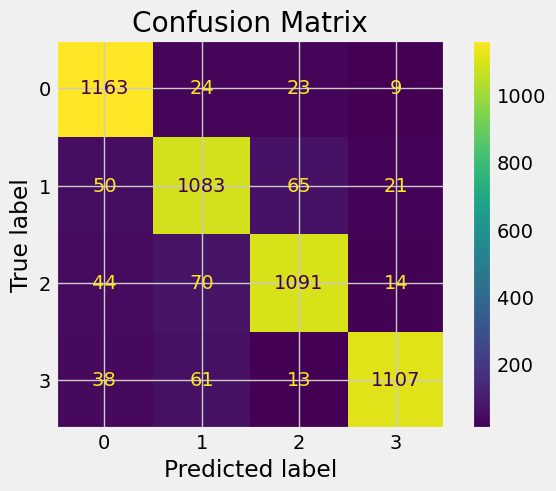

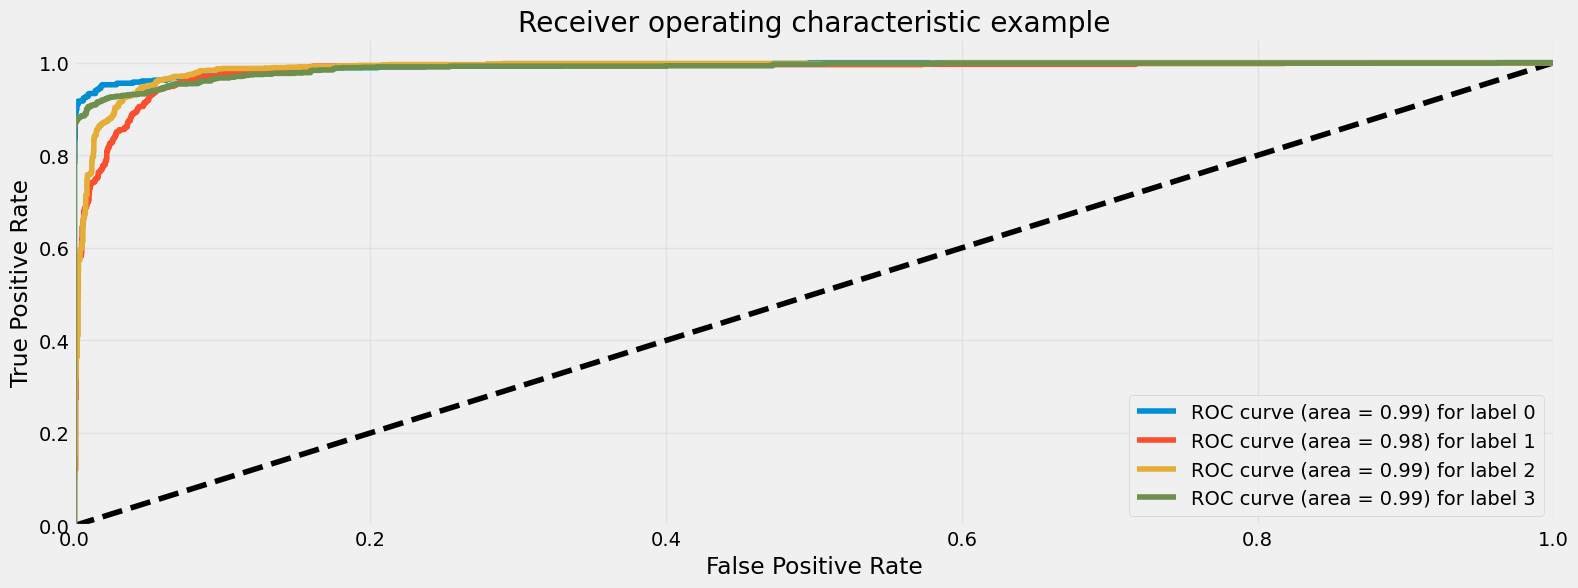

In [139]:
res_xgboost_task2 = train_and_plot(pipeline)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d871b9e-4e37-4fce-a22e-8733be6e4afc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>